# Introduction

In this note we 

* Demonstrate the basic steps needed to set up the Poisson problem
* Solve the problem 
* Demonstrate how these steps can be put inside the `tf.keras` functional API

In [1]:
import numpy as np
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
import tenfem
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.tri import Triangulation
from tenfem.layers import (AssembleStiffnessMatrix, AssembleLoadVector, SolveDirichletProblem,
                           TriangleMeshInterpolator)

tf_dtype = tf.float64
tfk = tf.keras
tfkl = tf.keras.layers

# The Poisson Problem

The Poisson problem is to PDE problems, and the FEM, what `Hello, world` is to coding exercises. Mathematically
we are interested in the following *boundary value problem*

$$
\begin{align}
    -\Delta u(x) = f(x), \qquad x \in \Omega \tag{1a} \\  
    u(x) = u_{D}(x) \qquad x \mbox{ on } \partial\Omega. \tag{1b}
\end{align}
$$

The goal is to find the unknown function $u(x)$ which solves this problem, that is for any $x$ inside
the domain $\Omega$ we satisfy (1a), and for any $x$ on the boundary $\partial \Omega$ we satisfy 
(1b). Here the boundary condition specified by the function $u_{D}$ is referred to as a Dirichlet
boundary condition, and the function $f(x)$ is typically referred to as the source or sink function.

If we want to implement such a problem then we need to specify our domain $\Omega$, and so this is where 
we go next.

## A `TriangleMesh` of $\Omega$

All of the domains will be specifed by decomising a subset $\Omega \subset \mathbb{R}^D$ into a collection
of disjoint polygonal regions sharing edges -- the eponymous *elements* of the finite element method. Below
we show an example which contains a regular tesselation of the unit square $\Omega = [0, 1] \times [0, 1]$ 
by triangle elements, this is an instance of a `tenfem.mesh.TriangleMesh` object.

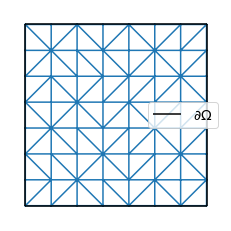

In [2]:
mesh = tenfem.mesh.examples.square(8, 8, dtype=tf_dtype)

fig, ax = plt.subplots()
ax.triplot(mesh._triang)

ax.add_collection(
    LineCollection(tf.gather(mesh.nodes, mesh.boundary_elements), colors='k', label='$\partial \Omega$'))
ax.legend(fontsize=14)
ax.set_aspect('equal'); ax.axis('off')
for method in [ax.set_xlim, ax.set_ylim]:
    method((-0.1, 1.1))

plt.show()

One of the beautiful aspects of the Finite Element Method is that while the original problem 
over the domain $\Omega$ is specified in terms of the "physical elements" -- our triangles 
in the mesh above. We solve the equation by considering each of these physical elements as
a transformation of a single canonical *reference element*, with a bijection between the 
physical elements and the canonical element, this abstraction is encapsulated by the 
`tenfem.reference_element.BaseReferenceElement` class.

## `AssembleStiffnessMatrix`

In [3]:
lin_tri_element = tenfem.reference_elements.TriangleElement(degree=1, dtype=tf_dtype)
mesh = tenfem.mesh.examples.square(16, 16, dtype=tf_dtype)  # lets make a higher res mesh to see the solution

diffusion_coefficient = lambda x: tf.ones_like(x)[..., 0]
source = lambda x: -6. * tf.ones_like(x)[..., 0]
ud = lambda x: (1 + x[...,0]**2 + 2. * x[..., 1]**2)[..., tf.newaxis]

def solve(mesh, element):
    mesh_tensor_repr = mesh.get_tensor_repr()

    stiffness_matrix = AssembleStiffnessMatrix(diffusion_coefficient,
                                               reference_element=element)(mesh_tensor_repr)
    load_vector = AssembleLoadVector(source,
                                     reference_element=element)(mesh_tensor_repr)
    node_types = mesh_tensor_repr[-1]
    boundary_values = ud(tf.gather_nd(mesh.nodes, tf.where(node_types == 1)))

    return tenfem.fem.solve_dirichlet_form_linear_system(
        stiffness_matrix[0], load_vector[0], node_types, boundary_values)

In [4]:
solution = solve(mesh, lin_tri_element)
solution_exact = ud(mesh.nodes)

err = np.max(np.abs(solution - solution_exact))

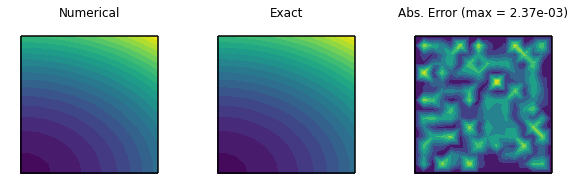

In [5]:
fig, axes = plt.subplots(ncols=3, figsize=(10, 6))

axes[0].tricontourf(mesh._triang, solution[:, 0], levels=20)
axes[1].tricontourf(mesh._triang, ud(mesh.nodes)[:, 0], levels=20)
axes[2].tricontourf(mesh._triang, np.abs(solution[:, 0] - solution_exact[:, 0]))

titles = ['Numerical', 'Exact', 'Abs. Error (max = {:.2e})'.format(err)]

for i, ax in enumerate(axes):
    ax.add_collection(
        LineCollection(tf.gather(mesh.nodes, mesh.boundary_elements), colors='k', label='$\partial \Omega$'))
    ax.set_aspect('equal'); ax.axis('off')
    for method in [ax.set_xlim, ax.set_ylim]:
        method((-0.1, 1.1))
    ax.set_title(titles[i])

plt.show()

For statistical applications and error of the magnitude above might be acceptable,
however this is less likely to be the case in engineering applications! How can
we decrease this error? One option is to specify a mesh with a finder resolution,
alternatively we can try and perform the numerical quadratures more accurately.

One of the most important ways this manifests is that whenever we are doing integration
over a physical element, we parameterise in terms of coordinates of the reference element,
and in practice specify integrations by quadratures over the reference element. Once
we have specified a quadrature order, all of the callable components of our model will be
queried for values at these quadrature nodes, so lets inspect them.

We provide a utility function to convert a standard triangular mesh to one suitable
for degree 2 basis functions in the `tenfem.mesh.triangle.convert_linear_to_quadratic`
function, and we use this to increase the degree of our approximations on the mesh, and
so we will also have to change the degree of the `TriangleElement` reference element
we are using.

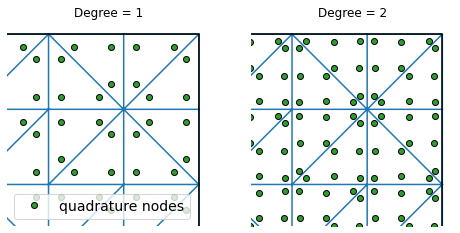

In [6]:
quad_mesh = tenfem.mesh.triangle.convert_linear_to_quadratic(mesh)
quad_tri_element = tenfem.reference_elements.TriangleElement(degree=2, dtype=tf_dtype)

elements = [lin_tri_element, quad_tri_element]
meshes = [mesh, quad_mesh]

fig, axes = plt.subplots(ncols=2, figsize=(8, 6))
for i, ax in enumerate(axes):

    quadrature_nodes = elements[i].get_quadrature_nodes(meshes[i])

    ax.triplot(mesh._triang)

    ax.plot(*tf.reshape(quadrature_nodes, [-1, 2]).numpy().T, 
            'o', markeredgecolor='k', label='quadrature nodes' if i == 0 else None)
    ax.add_collection(
        LineCollection(tf.gather(mesh.nodes, mesh.boundary_elements), colors='k'))

    if i == 0:
        ax.legend(fontsize=14, loc='lower left')

    ax.set_aspect('equal'); ax.axis('off')
    for method in [ax.set_xlim, ax.set_ylim]:
        method((0.83, 1.01))
        
    ax.set_title('Degree = {}'.format(i+1))
plt.show()

We can see that the actualy number of elements hasn't changed, but
that while before we approximated each one with 3 quadrature nodes
we now use 6. As such the total number of nodes over which we need
to solve the FEM problem has increased. 

Now that we have increase the degree of our basis functions on the 
mesh elements lets solve the problem, and then plot the results

In [7]:
sol_deg2 = solve(quad_mesh, quad_tri_element)
solution_exact = ud(quad_mesh.nodes)
err = np.max(np.abs(sol_deg2 - solution_exact))

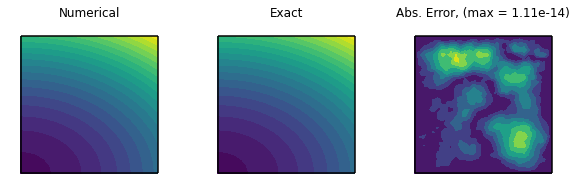

In [8]:
mtri = Triangulation(*quad_mesh.nodes.numpy().T)

fig, axes = plt.subplots(ncols=3, figsize=(10, 6))


axes[0].tricontourf(mtri, sol_deg2[:, 0], levels=20)
axes[1].tricontourf(mtri, ud(quad_mesh.nodes)[:, 0], levels=20)
axes[2].tricontourf(mtri, np.abs(sol_deg2[:, 0] - solution_exact[:, 0]))

titles = ['Numerical' % err, 'Exact', 'Abs. Error, (max = {:.2e})'.format(err)]

for i, ax in enumerate(axes):
    ax.add_collection(
        LineCollection(tf.gather(mesh.nodes, mesh.boundary_elements), colors='k', label='$\partial \Omega$'))
    ax.set_aspect('equal'); ax.axis('off')
    for method in [ax.set_xlim, ax.set_ylim]:
        method((-0.1, 1.1))
    ax.set_title(titles[i])

# PDE inside of a `tf.keras.Model`

In [9]:
mesh_provider = tenfem.layers.MeshProvider(quad_mesh,
                                           quad_tri_element)
source = tfkl.Dense(1)
#source = lambda x: -6. * tf.ones_like(x)[..., 0]


inputs = tfkl.Input(2, dtype=tf_dtype)
mesh_tensor_repr = mesh_provider(inputs)

stiffness_matrix = AssembleStiffnessMatrix(
    diffusion_coefficient,
    reference_element=mesh_provider.reference_element)(mesh_tensor_repr)

load_vector = AssembleLoadVector(source,
                                 reference_element=mesh_provider.reference_element,
                                 name='assemble_load_vector')(mesh_tensor_repr)

u = SolveDirichletProblem(ud, 
                          reference_element=mesh_provider.reference_element)(
    [stiffness_matrix,
     load_vector,
     mesh_tensor_repr])

ux = TriangleMeshInterpolator(tri_finder=mesh._triang.get_trifinder(),
                              reference_element=mesh_provider.reference_element)(
    [inputs, u, mesh_tensor_repr])

model = tfk.Model(inputs=inputs, outputs=ux)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
mesh_provider (MeshProvider)    ((961, 2), (450, 6), 0           input_1[0][0]                    
__________________________________________________________________________________________________
assemble_stiffness_matrix (Asse (1, 961, 961)        0           mesh_provider[0][0]              
                                                                 mesh_provider[0][1]              
                                                                 mesh_provider[0][2]              
                                                                 mesh_provider[0][3]          

In [10]:
inputs = np.random.uniform(size=100*2).reshape(100, 2)
targets = ud(inputs)

model.compile(optimizer='rmsprop', loss='mean_squared_error')
history = model.fit(inputs, targets, epochs=100)

Epoch 1/100
4/4 [==============================] - 0s 33ms/step - loss: 0.0605
Epoch 2/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0602
Epoch 3/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0600
Epoch 4/100
4/4 [==============================] - 0s 31ms/step - loss: 0.0599
Epoch 5/100
4/4 [==============================] - 0s 36ms/step - loss: 0.0597
Epoch 6/100
4/4 [==============================] - 0s 31ms/step - loss: 0.0595
Epoch 7/100
4/4 [==============================] - 0s 33ms/step - loss: 0.0594
Epoch 8/100
4/4 [==============================] - 0s 31ms/step - loss: 0.0592
Epoch 9/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0590
Epoch 10/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0589
Epoch 11/100
4/4 [==============================] - 0s 31ms/step - loss: 0.0587
Epoch 12/100
4/4 [==============================] - 0s 31ms/step - loss: 0.0586
Epoch 13/100
4/4 [==============================]